# Анализ страховых взносов страхователей из США

## Описание данных

Датасет взят с kaggle.com
* **age**: age of primary beneficiary
* **sex**: insurance contractor gender, female, male
* **bmi**: Body mass index, providing an understanding of body, weights that are relatively high or low relative to height,
objective index of body weight (kg / m ^ 2) using the ratio of height to weight, ideally 18.5 to 24.9
* **children**: Number of children covered by health insurance / Number of dependents
* **smoker**: Smoking
* **region**: the beneficiary's residential area in the US, northeast, southeast, southwest, northwest.
* **charges**: Individual medical costs billed by health insurance

**Цель проекта** - анализ страхователей из США и построение модели прогноза страховых взносов.

## План работ:

* Предобработка данных
* Исследовательский анализ (EDA)
* Модель расчета страховых взносов
* Построение прогноза на датасете с произвольными данными

## Предобработка данных

In [1]:
import pandas as pd
import pandas_profiling
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import Lasso, Ridge, LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [2]:
data = pd.read_csv('insurance.csv')
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [3]:
# профилирование данных

pandas_profiling.ProfileReport(data)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

**Вывод**:

В датасете нет пропущенных данных. Присутствует строка-дубликат, но нет достаточно данных, чтобы точно определить, что это дубликат, возможно, это разные люди с совпадающим профилем.
Есть 1338 профилей страхователей возрастом от 18 до 64 лет, проживающих во всех 4х частях США (юго-восток, юго-запад, северо-восток, северо-запад), имеющих от 0 до 5 детей и внесших страховую сумму в рамере от 1121.87 до 63770.43 долларов. Количество некурящих страхователей сильно превышает (в 3.88 раз) количество курящих. Распределение по половому признаку (мужчина/женщина) примерно одинаково, но мужчин больше на 2% (или на 14 человек). Индекс массы тела (ИМТ) страхователей находится в диапазоне 15.96-53.13 с пиком в районе 30 при норме 18.5-24.9.
Сумма страхового взноса сильно зависит от курения человека и в чуть меньшей степени от возраста.

## Исследовательский анализ (EDA)

### Возраст страхователей

In [4]:
# создаем 2 дополнительных датасета с разбивкой по полу страхователя

data_men = pd.DataFrame(data.query('sex == "male"'))
data_women = pd.DataFrame(data.query('sex == "female"'))

In [5]:
# задаем функцию для построения гистограмм

def hist(data, argument, title_1, title_2, xlabel):
    
    ax = plt.figure().gca()
    data[argument].hist(bins=100, figsize=(8, 4), ec='black')
    
    plt.title('Распределение {}. {}'.format(title_1, title_2))
    plt.xlabel(xlabel)
    plt.ylabel('Частота')
    plt.xticks(rotation=45, horizontalalignment='right')
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    plt.show()

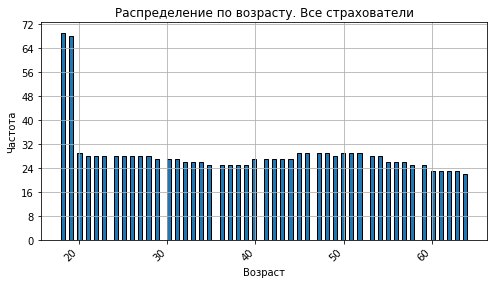

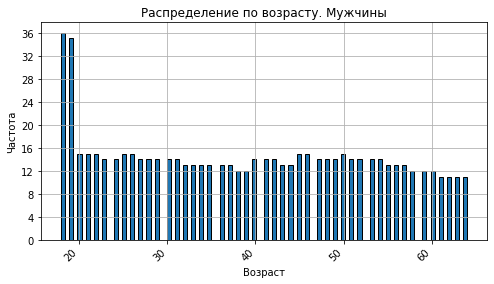

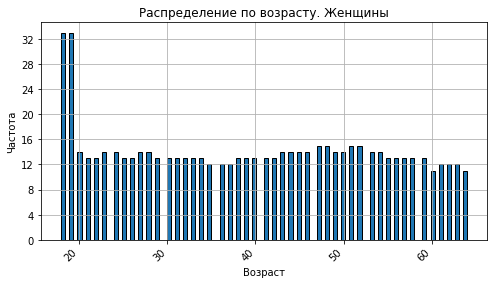

In [6]:
datasets = [data, data_men, data_women]
sex = ['Все страхователи', 'Мужчины', 'Женщины']

for index in [0, 1, 2]:
    hist(datasets[index], 'age', 'по возрасту', sex[index], 'Возраст')

Среди всех страхователей (и в общем датасете, и отдельно среди мужчин и женщин) наибольшее количество страхователей - это люди 18-19 лет (на каждый из этих двух возрастов приходится в 2.3 раза больше страхователей, чем на любой другой возраст). Страхователи остальных возрастов распределены примерно равномерно как у мужчин, так и у женщин.

### Количество детей

In [7]:
# задаем функцию для построения графика рассеяния

def scatter(x, y, xlabel, ylabel, title_1, title_2):
    
    plt.figure(figsize=(8,4))
    
    plt.scatter(x, y, alpha=0.1)
    
    plt.title('Зависимость {} от {}'.format(title_1, title_2))
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(rotation=45, horizontalalignment='right')
    plt.show()

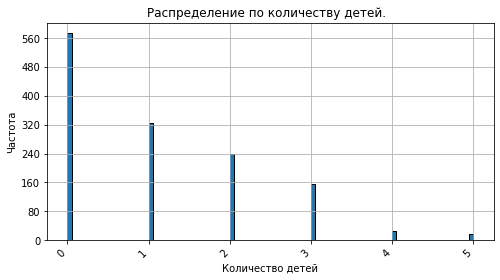

In [8]:
# распределение количества детей по возрасту

hist(data, 'children', 'по количеству детей', ' ', 'Количество детей')

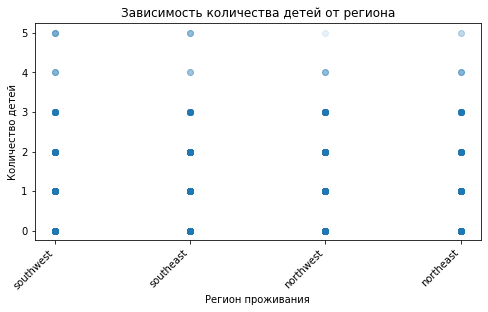

In [9]:
# распределение количества детей по регионам проживания

scatter(data['region'], data['children'], 'Регион проживания', 'Количество детей', 'количества детей', 'региона')

У 45% страхователей нет детей, у 24% - 1 ребенок, у 18% - 2 детей. 4 или 5 детей совсем у небольшого количества страхователей. Больше 3 детей в семье больше характерно для южных регионов.

### Курение

In [10]:
# распределение курящих по полу

print('Курящих мужчин: {}'.format(data_men.query('smoker == "yes"')['age'].count()))
print('Курящих женщин: {}'.format(data_women.query('smoker == "yes"')['age'].count()))

Курящих мужчин: 159
Курящих женщин: 115


In [11]:
# зависимость курения от возраста

# задаем функцию для категоризоции по возрастному диапазону
def age_group(age):
    
    if age <=20:
        return '20 less'
    
    if 21 <= age <= 30:
        return '21-30'
    
    if 31 <= age <= 40:
        return '31-40'
    
    if 41 <= age <= 50:
        return '41-50'
    
    return '50+'

data['age_group'] = data['age'].apply(age_group)

In [12]:
# считаем количество курящих на каждый возрастной диапазон с разбивкой по полу

data_grouped_age = (
    data
    .groupby(['age_group', 'smoker', 'sex'], as_index=False)
    .agg({'age': 'count'})
)

# считаем общее количество страхователей с группировкой по возрастному дапазону
data_total_age = (
    data
    .groupby(['age_group'], as_index=False)
    .agg({'age': 'count'})
)

data_merged_age = data_grouped_age.merge(data_total_age, on='age_group', how='left')
data_merged_age.columns = ['age_group', 'smoker', 'sex', 'count', 'total']

# считаем %% курящих на каждый возрастной диапазон с разбивкой по полу
data_merged_age['percent_of_smokers'] = (
    (data_merged_age['count'] / data_merged_age['total'] *100)
    .round(1)
)
data_merged_age.query('smoker == "yes"') 

,age_group,smoker,sex,count,total,percent_of_smokers
2,20 less,yes,female,17,166,10.2
3,20 less,yes,male,22,166,13.3
6,21-30,yes,female,23,278,8.3
7,21-30,yes,male,33,278,11.9
10,31-40,yes,female,22,257,8.6
11,31-40,yes,male,32,257,12.5
14,41-50,yes,female,26,281,9.3
15,41-50,yes,male,35,281,12.5
18,50+,yes,female,27,356,7.6
19,50+,yes,male,37,356,10.4


In [13]:
# зависимость курения от количества детей

# считаем количество курящих на каждое количество детей

data_grouped_children = (
    data
    .groupby(['children', 'smoker', 'sex'], as_index=False)
    .agg({'age': 'count'})
)

# считаем общее количество страхователей с группировкой по количеству детей
data_total_children = (
    data
    .groupby(['children'], as_index=False)
    .agg({'age': 'count'})
)


data_merged_children = data_grouped_children.merge(data_total_children, on='children', how='left')
data_merged_children = data_merged_children.rename(columns = {'age_x': 'count', 'age_y': 'total'})

# считаем %% курящих на каждое количество детей
data_merged_children['percent_of_smokers'] = (
    (data_merged_children['count'] / data_merged_children['total'] *100)
    .round(1)
)
data_merged_children.query('smoker == "yes"')

,children,smoker,sex,count,total,percent_of_smokers
2,0,yes,female,53,574,9.2
3,0,yes,male,62,574,10.8
6,1,yes,female,25,324,7.7
7,1,yes,male,36,324,11.1
10,2,yes,female,22,240,9.2
11,2,yes,male,33,240,13.8
14,3,yes,female,14,157,8.9
15,3,yes,male,25,157,15.9
18,4,yes,male,3,25,12.0
21,5,yes,female,1,18,5.6


Курящих мужчин в целом больше, чем курящих женщин - 58% мужчин курят против 42% у женщин. И в каждом возрастном диапазоне процент курящих мужчин выше а 3-4 пункта, чем женщин. Наиболее высокие %% курящих среди страхователей младше 20 лет.
Среди тех, у кого 2-3 детей, %% курящих выше, при этом наиболее высокий %% курящих женщин среди тех, у кого нет детей и у кого 2 детей.

### Индекс массы тела

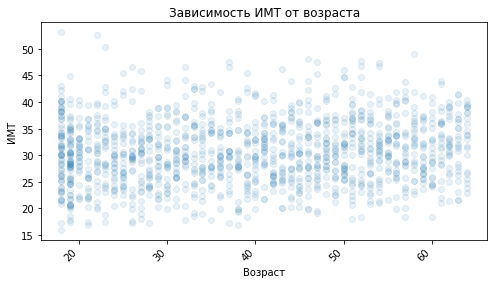

In [14]:
# зависимость ИМТ от возраста

scatter(data['age'], data['bmi'], 'Возраст', 'ИМТ', 'ИМТ', 'возраста')

In [15]:
# страхователи с имт, выше нормы

print('Страхователей с имт выше нормы: {:.1%}'.format(data.query('bmi > 24.9')['age'].count() / data['age'].count()))

Страхователей с имт выше нормы: 81.9%


In [16]:
# считаем средний и медианный ИМТ для каждого возрастного диапазона

bmi_by_age = (
    data
    .groupby('age_group', as_index=False)
    .agg({'bmi': ['mean', 'median']})
    .round(2)
)

bmi_by_age.columns = ['age_group', 'bmi_mean', 'bmi_median']

bmi_by_age

,age_group,bmi_mean,bmi_median
0,20 less,30.09,30.12
1,21-30,29.77,29.62
2,31-40,30.40,29.80
3,41-50,30.81,30.30
4,50+,31.70,31.82


In [17]:
# считаем средний и медианный ИМТ для каждого возрастного диапазона с разбивкой на курящих/не-курящих

bmi_by_age_smoker = (
    data
    .groupby(['age_group', 'smoker'], as_index=False)
    .agg({'bmi': ['mean', 'median']})
    .round(2)
)

bmi_by_age_smoker.columns = ['age_group', 'smoker', 'bmi_mean', 'bmi_median']

bmi_by_age_smoker

,age_group,smoker,bmi_mean,bmi_median
0,20 less,no,30.09,30.14
1,20 less,yes,30.08,29.07
2,21-30,no,29.54,29.33
3,21-30,yes,30.72,30.71
4,31-40,no,30.45,29.74
5,31-40,yes,30.21,30.07
6,41-50,no,30.90,30.54
7,41-50,yes,30.48,30.00
8,50+,no,31.70,31.82
9,50+,yes,31.73,31.57


In [18]:
# считаем средний и медианный ИМТ для каждого возрастного диапазона с разбивкой по полу

bmi_by_age_sex = (
    data
    .groupby(['age_group', 'sex'], as_index=False)
    .agg({'bmi': ['mean', 'median']})
    .round(2)
)

bmi_by_age_sex.columns = ['age_group', 'sex', 'bmi_mean', 'bmi_median']

bmi_by_age_sex

,age_group,sex,bmi_mean,bmi_median
0,20 less,female,30.72,30.54
1,20 less,male,29.50,29.55
2,21-30,female,28.87,28.54
3,21-30,male,30.61,30.54
4,31-40,female,29.81,29.30
5,31-40,male,30.98,30.14
6,41-50,female,30.96,30.35
7,41-50,male,30.65,30.30
8,50+,female,31.29,31.73
9,50+,male,32.13,32.11


In [19]:
# зависимость ИМТ каждого возрастного диапазона от региона проживания

bmi_by_age_region = (
    data
    .groupby(['age_group', 'region'], as_index=False)
    .agg({'bmi': ['mean', 'median']})
    .round(2)
)

bmi_by_age_region.columns = ['age_group', 'region', 'bmi_mean', 'bmi_median']

bmi_by_age_region

,age_group,region,bmi_mean,bmi_median
0,20 less,northeast,29.02,28.98
1,20 less,northwest,28.85,28.98
2,20 less,southeast,33.40,33.33
3,20 less,southwest,28.36,28.40
4,21-30,northeast,27.37,27.26
5,21-30,northwest,28.00,28.40
6,21-30,southeast,33.60,33.11
7,21-30,southwest,29.74,30.10
8,31-40,northeast,28.72,27.93
9,31-40,northwest,29.10,28.64


В каждом возрастном диапазоне средний ИМТ составляет 29-30, что явно превышает норму. При этом уровень ИМТ не зависит от того, курит страхователь или нет, а также в целом не зависит от пола страхователя.  В датасете 82% страхователей имеют ИМТ выше 24.9.  
Прослеживается четкая зависимоть ИМТ от региона проживания. В каждом возрастном диапазоне наиболее высокий ИМТ у проживающих на юго-востоке страны, и, в целом, у проживающих на юге ИМТ выше, чем у тех, кто живет на севере страны.

### Страховые взносы

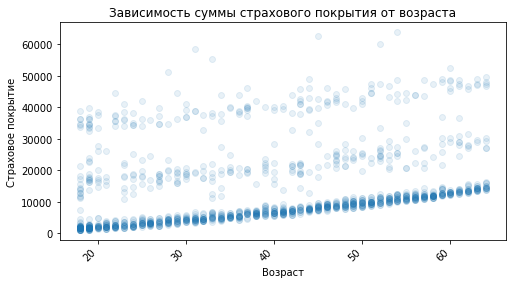

In [20]:
# зависимость страхового покрытия от возраста

scatter(data['age'], data['charges'], 'Возраст', 'Страховое покрытие', 'суммы страхового покрытия', 'возраста')

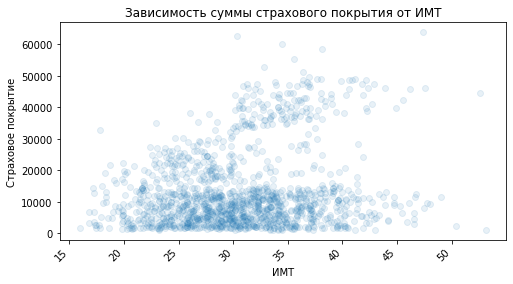

In [21]:
# зависимость страхового покрытия от ИМТ

scatter(data['bmi'], data['charges'], 'ИМТ', 'Страховое покрытие', 'суммы страхового покрытия', 'ИМТ')

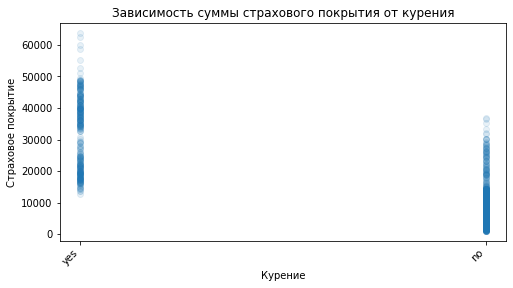

In [22]:
# зависимость страхового покрытия от курения

scatter(data['smoker'], data['charges'], 'Курение', 'Страховое покрытие', 'суммы страхового покрытия', 'курения')

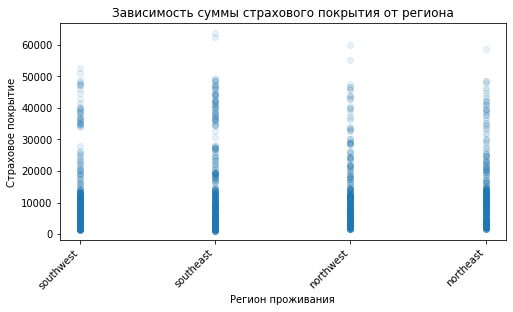

In [23]:
# зависимость страхового покрытия от региона проживания

scatter(data['region'], data['charges'], 'Регион проживания', 'Страховое покрытие', 'суммы страхового покрытия', 'региона')

Сумма страхового покрытия зависит от курения и от возраста. Зависимость от ИМТ не настолько явная, но, тем не менее, наиболее высокие суммы страховых покрытий произведены при ИМТ в диапазоне 30-40. Соответственно, так как в юго-восточном регионе наиболее высокий уровень ИМТ, то там и сумма страхования выше.

### Вывод по исследовательскому анализу

Представлен датасет о данных страхователей США возрастом от 18 до 64 лет, проживающих во всех 4х частях США (юго-восток, юго-запад, северо-восток, северо-запад), имеющих от 0 до 5 детей и внесших страховую сумму в рамере от 1121.87 до 63770.43 долларов.

Наибольшее количество страхователей - это персоны 18-19 лет.  
Среди всех страхователей преобладают некурящие бездетные персоны - у 45% страхователей нет детей, только 20% от всех страхователей курят. При этом курящих мужчин больше, чем курящих женщин - 58% мужчин курят против 42% женщин. Наиболее высокие проценты курящих среди страхователей младше 20 лет.  
У 24% страхователей - 1 ребенок, у 18% - 2 детей. Большее количество детей характерно для южных регионов.

Индекс массы тела (ИМТ) страхователей находится в диапазоне 15.96-53.13 с пиком в районе 30 при норме 18.5-24.9. 82% страхователей имеют ИМТ выше нормы. Уровень ИМТ не зависит от того, курит страхователь или нет, а также не зависит от пола или возраста страхователя. Прослеживается четкая зависимоть ИМТ от региона проживания: наиболее высокий ИМТ у проживающих на юго-востоке страны.  

Сумма страхового взноса зависит от курения и от возраста. Зависимость от ИМТ не явная, но наиболее высокие суммы страховых покрытий произведены при ИМТ в диапазоне 30-40.

## Модель расчета страховых взносов

In [24]:
# выбираем наиболее подходящую модель для обучения

# разделяим данные на признаки (матрица X) и целевую переменную (y)
X = data.drop(columns=['charges', 'age_group'])
y = data['charges']

# меняем строковые данные на тип 'integer', где необходимо
X['smoker'] = (X['smoker'] == "yes").astype(int)
X['sex'] = X['sex'].map({'male':'0','female':'1'})
X['region'] = X['region'].map({'southwest':'1','southeast':'2', 'northwest':'3', 'northeast':'4'})

# разделяем модель на обучающую и валидационную выборку и стандартизируем данные
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

scaler = StandardScaler()
X_train_st = scaler.fit_transform(X_train)
X_test_st = scaler.transform(X_test)

# задаем список моделей
models = [
    Lasso(),
    Ridge(),
    DecisionTreeRegressor(),
    RandomForestRegressor(),
    GradientBoostingRegressor()
]

# функция, которая вычисляет MAPE (средняя абсолютная ошибка в процентах)
def mape(y_true, y_pred):
    y_error = y_true - y_pred
    y_error_abs = [abs(i) for i in y_error]
    perc_error_abs = y_error_abs / y_true
    mape = perc_error_abs.sum() / len(y_true)
    return mape


# функция, которая принимает на вход модель и данные и выводит метрики
def make_prediction(m, X_train, y_train, X_test, y_test):
    model = m
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(
        'MAE:{:.2f} MSE:{:.2f} MAPE:{:.2f} R2:{:.2f} '.format(
            mean_absolute_error(y_test, y_pred),
            mean_squared_error(y_test, y_pred),
            mape(y_test, y_pred),
            r2_score(y_test, y_pred),
        )
    )


# выводим метрики по списку моделей
for i in models:
    print(i)
    make_prediction(
        m=i,
        X_train=X_train_st,
        y_train=y_train,
        X_test=X_test_st,
        y_test=y_test,
    )

Lasso()
MAE:4468.03 MSE:41196446.56 MAPE:0.40 R2:0.76 
Ridge()
MAE:4469.59 MSE:41196807.95 MAPE:0.40 R2:0.76 
DecisionTreeRegressor()
MAE:2943.43 MSE:40694985.77 MAPE:0.25 R2:0.76 
RandomForestRegressor()
MAE:2496.42 MSE:23233118.03 MAPE:0.25 R2:0.86 
GradientBoostingRegressor()
MAE:2404.67 MSE:21047073.93 MAPE:0.25 R2:0.88 


Наилучшие показатели у модели градиентного бустинга.

In [25]:
# обучаем модель и делаем прогноз для валидационной выборки

final_model = GradientBoostingRegressor()
final_model.fit(X_train_st, y_train)
y_pred = final_model.predict(X_test_st)

In [26]:
# анализируем важность признаков

importances = final_model.feature_importances_
data_features = pd.DataFrame({'name': X.columns, 'importances': importances})
print(data_features.sort_values(by='importances', ascending=False))

       name  importances
4    smoker     0.686039
2       bmi     0.176171
0       age     0.125722
3  children     0.007793
5    region     0.003781
1       sex     0.000495


In [27]:
# анализируем различие между полученным прогнозом и реальными значениями валидационной выборки

diff_y = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred})
diff_y['difference'] = ((diff_y['y_pred'] / diff_y['y_test'] -1) *100).round(1)
diff_y = diff_y.sort_values(by='difference', ascending=False)

# определяем, какой % данных попадает в разницу в 10% по сравнению с реальными значениями
print(
    '{:.1%} данных имеют разницу <= 10% с реальными данными, остальные данные имеют большую разницу'
    .format(
        diff_y.query('-10 <= difference <= 10 ')['difference'].count()
         / diff_y['difference'].count()
    )
)

38.4% данных имеют разницу <= 10% с реальными данными, остальные данные имеют большую разницу


In [28]:
# задаем блоки параметров для определения наилучших (пример взят отсюда https://habr.com/ru/company/nix/blog/425907/)

loss = ['ls', 'lad', 'huber']
n_estimators = [50, 100, 200, 300, 500]
max_depth = [2, 3, 5, 10, 15]
min_samples_leaf = [1, 2, 4, 6, 8]
min_samples_split = [2, 4, 6, 10]
max_features = ['auto', 'sqrt', 'log2', None]

# определяем сетку параметров для поиска
hyperparameter_grid = {'loss': loss,
    'n_estimators': n_estimators,
    'max_depth': max_depth,
    'min_samples_leaf': min_samples_leaf,
    'min_samples_split': min_samples_split,
    'max_features': max_features}

# создаем модель, где будем использовать вышеуказанную сетку
model_new = GradientBoostingRegressor(random_state = 42)

# запускаем поиск Set up the random search with 4-fold cross validation
random_cv = RandomizedSearchCV(model_new,
    hyperparameter_grid,
    cv=None, n_iter=5, 
    scoring = 'neg_mean_absolute_error',
    n_jobs = -1, verbose = 1, 
    return_train_score = True,
    random_state=42)

# обучаем модель заново
random_cv.fit(X_train_st, y_train) #After performing the search, we can inspect the RandomizedSearchCV object to find the best model:
y_pred_random = random_cv.predict(X_test_st)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


In [29]:
# выводим лучшие метрики

print(" Results from Random Search " )
print("\n The best estimator across ALL searched params:\n", random_cv.best_estimator_)
print("\n The best score across ALL searched params:\n", random_cv.best_score_)
print("\n The best parameters across ALL searched params:\n", random_cv.best_params_)

 Results from Random Search 

 The best estimator across ALL searched params:
 GradientBoostingRegressor(loss='huber', max_depth=5, min_samples_leaf=8,
                          min_samples_split=6, random_state=42)

 The best score across ALL searched params:
 -1950.676881016879

 The best parameters across ALL searched params:
 {'n_estimators': 100, 'min_samples_split': 6, 'min_samples_leaf': 8, 'max_features': None, 'max_depth': 5, 'loss': 'huber'}


In [30]:
# анализируем различие между полученным прогнозом и реальными значениями валидационной выборки после применения Random Search

diff_y_random = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred_random})
diff_y_random['difference'] = ((diff_y_random['y_pred'] / diff_y_random['y_test'] -1) *100).round(1)
diff_y_random = diff_y_random.sort_values(by='difference', ascending=False)

# определяем, какой % данных попадает в разницу в 10% по сравнению с реальными значениями
print(
    '{:.1%} данных имеют разницу <= 10% с реальными данными после применения random search, остальные данные имеют большую разницу'
    .format(
        diff_y_random.query('-10 <= difference <= 10 ')['difference'].count()
         / diff_y_random['difference'].count()
    )
)

70.1% данных имеют разницу <= 10% с реальными данными после применения random search, остальные данные имеют большую разницу


После применения random search точность проноза повысилась, и % попадания в разницу меньше10% с реальными данными повысился минимум на 30 пунктов.

## Построение прогноза на датасете с произвольными данными

In [31]:
# создаем датасет страхователей с рандомными данными для получения прогноза страхового покрытия для них

n = 500
df = pd.DataFrame(dict(
    age=np.random.randint(18, 100, size=n),
    sex=np.random.randint(0, 2, size=n),
    bmi=np.random.randint(15, 55, size=n).astype(float),
    children=np.random.randint(0, 4, size=n),
    smoker=np.random.randint(0, 2, size=n),
    region=np.random.randint(1, 5, size=n)
))

df.head(10)

,age,sex,bmi,children,smoker,region
0,61,1,32.0,1,0,1
1,89,0,17.0,3,1,1
2,66,0,40.0,3,1,3
3,29,0,53.0,1,1,4
4,69,0,54.0,3,1,3
5,95,1,19.0,2,1,2
6,46,1,35.0,1,1,2
7,34,1,52.0,3,1,1
8,27,0,50.0,2,0,3
9,69,1,44.0,0,1,1


In [32]:
# получаем прогноз

df_st = scaler.transform(df)
charges_predicted = random_cv.predict(df_st).round(5)

df['charges'] = charges_predicted

df.head(10)

,age,sex,bmi,children,smoker,region,charges
0,61,1,32.0,1,0,1,15521.44693
1,89,0,17.0,3,1,1,27944.10786
2,66,0,40.0,3,1,3,48939.32101
3,29,0,53.0,1,1,4,43986.24079
4,69,0,54.0,3,1,3,49866.62432
5,95,1,19.0,2,1,2,27685.59913
6,46,1,35.0,1,1,2,41617.54331
7,34,1,52.0,3,1,1,44880.85743
8,27,0,50.0,2,0,3,3879.83288
9,69,1,44.0,0,1,1,49143.62383
